In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
log_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/log/"

maps = np.concatenate([np.load(log_dir + f + "/maps.npy") for f in os.listdir(log_dir) if f.find("2023") == 0], axis=0)

maps[maps == 100] = 1
maps += 1
maps = torch.from_numpy(maps).to(torch.float32)
maps /= maps.max()

maps = maps.reshape(-1, 1, 384, 384)


In [28]:
maps.shape

torch.Size([11849, 1, 384, 384])

In [29]:
s = maps.sum(axis=[-1, -2]) / (384 * 384)

In [35]:
# plt.figure(figsize=(20, 10))
# plt.plot(s[:1000])

In [31]:
maps.shape

torch.Size([11849, 1, 384, 384])

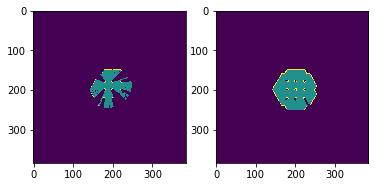

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(maps[0].numpy().reshape(384, 384))
# plt.show()
plt.subplot(1, 2, 2)
plt.imshow(maps[-1].numpy().reshape(384, 384))
plt.show()

In [13]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(4, 4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(4, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


encoder = Encoder()
m = torch.rand(10, 1, 384, 384)
encoder(m).shape

torch.Size([10, 256])

In [14]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, kernel_size=3),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(4, 4, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, kernel_size=3),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x.reshape(-1, 64, 2, 2)
        x = self.decoder(x)
        return x


decoder = Decoder()
m = torch.rand(10, 256)
decoder(m).shape

torch.Size([10, 1, 384, 384])

In [15]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


autoencoder = Autoencoder()

In [16]:
cirterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [17]:
maps = maps.to(device)
autoencoder = autoencoder.to(device)

In [18]:
dataset = data_utils.TensorDataset(maps)
data_loader = data_utils.DataLoader(dataset, batch_size=128, shuffle=True)

In [401]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.
    for i, [img] in enumerate(data_loader):
        outputs = autoencoder(img)
        loss = cirterion(outputs, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_loader)}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {total_loss / len(data_loader):.4f}")
    print()

Epoch [1/10], Step [5/15], Loss: 0.0016
Epoch [1/10], Step [10/15], Loss: 0.0016
Epoch [1/10], Step [15/15], Loss: 0.0016
Epoch [1/10], Average Loss: 0.0016

Epoch [2/10], Step [5/15], Loss: 0.0017
Epoch [2/10], Step [10/15], Loss: 0.0015
Epoch [2/10], Step [15/15], Loss: 0.0016
Epoch [2/10], Average Loss: 0.0016

Epoch [3/10], Step [5/15], Loss: 0.0017
Epoch [3/10], Step [10/15], Loss: 0.0016
Epoch [3/10], Step [15/15], Loss: 0.0015
Epoch [3/10], Average Loss: 0.0016

Epoch [4/10], Step [5/15], Loss: 0.0015
Epoch [4/10], Step [10/15], Loss: 0.0016
Epoch [4/10], Step [15/15], Loss: 0.0016
Epoch [4/10], Average Loss: 0.0015

Epoch [5/10], Step [5/15], Loss: 0.0015
Epoch [5/10], Step [10/15], Loss: 0.0015
Epoch [5/10], Step [15/15], Loss: 0.0016
Epoch [5/10], Average Loss: 0.0015

Epoch [6/10], Step [5/15], Loss: 0.0017
Epoch [6/10], Step [10/15], Loss: 0.0016
Epoch [6/10], Step [15/15], Loss: 0.0015
Epoch [6/10], Average Loss: 0.0016

Epoch [7/10], Step [5/15], Loss: 0.0015
Epoch [7/10]

In [19]:
index = 5


def f(index):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 2)
    plt.imshow(maps_test[index].cpu().squeeze())

    with torch.no_grad():
        result = autoencoder(maps_test[index])
    plt.subplot(1, 2, 1)
    plt.imshow(result.reshape(384, 384).cpu().numpy())
    plt.show()

In [34]:
# f(164)

In [33]:
# for i in range(100):
    # print(i)
    # f(i)

In [409]:
maps[0].squeeze()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

/home/asad/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


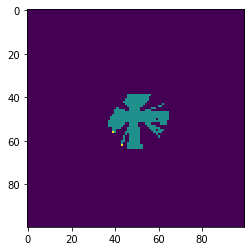

In [90]:
plt.imshow(transforms.Resize((100, 100))(torch.from_numpy(maps[:1])).reshape(100, 100))

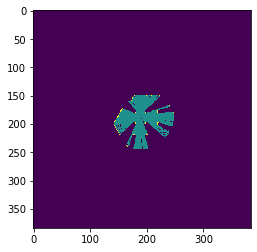

In [277]:
plt.imshow(maps[0])

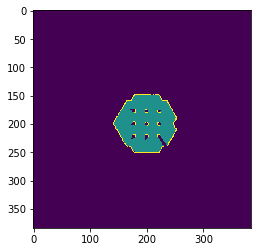

In [23]:
plt.imshow(maps[-1])
plt.show()